# Script to explore radar picks

## Import packages

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt
from haversine import haversine, Unit
import numpy as np
import pandas as pd

# complicated plotting
import rasterio
from rasterio.plot import show
import pyproj

from geopy.distance import distance
from geopy import Point


## set basic parameters

In [11]:

# define cores

class core:
    def __init__(self, name, lat, lon, depth):
        self.name = name
        self.lat = lat
        self.lon = lon
        self.depth = depth

    def get_dist_to_track(self,lat,lon):

        self.track_dist=10000
        for i in range(len(lat)):
            d = haversine((lat[i],lon[i]),(self.lat,self.lon),unit=Unit.METERS)
            if d < self.track_dist:
                self.track_dist = d
                self.track_idx = i

ALHIC2302 = core('ALHIC2302',-76.74543,159.37513, 143)
ALHIC2201 = core('ALHIC2201',-76.732027,159.359551, 90)
ALHIC1902 = core('ALHIC1902',-76.745357,159.374108, 206.53)
ALHIC1901 = core('ALHIC1901',-76.732376,159.356125, 159.84)
ALHIC2301 = core('ALHIC2301',-76.76145,159.40830,89)

## Basic data import and exploration

In [12]:
# Function to load the shapefile and check basic information
def load_shapefile(file_path):
    try:
        # Load the shapefile using geopandas
        gdf = gpd.read_file(file_path)
        
        # Display basic information about the data
        print("Loaded shapefile successfully!")
        print("Number of features:", len(gdf))
        print("CRS (Coordinate Reference System):", gdf.crs)
        print("First few rows of the data:")
        print(gdf.head())
        
        # Show the columns in the shapefile
        print("\nColumns in the shapefile:")
        print(gdf.columns)

        # You can access the geometry (the spatial component) and attributes here
        print("\nSample geometry:")
        print(gdf.geometry.head())

    except Exception as e:
        print(f"Error loading shapefile: {e}")

    return gdf

# Provide the path to the .shp file
#shapefile_path = "../../../radar_picks/picks-v2-culled-2melev.shp"
shapefile_path = "../../../radar_picks/picks-v2-culled.shp"
gdf = load_shapefile(shapefile_path)


Loaded shapefile successfully!
Number of features: 26422
CRS (Coordinate Reference System): EPSG:3031
First few rows of the data:
  Filename  St. Scan  End Scan      Lat()      Long() Layer 1 Na  Layer 1 Sc  \
0     None         0      6008 -76.733516  159.345061    Layer 1        1640   
1     None         0      6008 -76.733500  159.345184    Layer 1        1650   
2     None         0      6008 -76.733482  159.345314    Layer 1        1660   
3     None         0      6008 -76.733463  159.345453    Layer 1        1670   
4     None         0      6008 -76.733446  159.345595    Layer 1        1680   

   Layer 1 De  Layer 1 2-  Layer 1 La Layer 2 Na  Layer 2 Sc Layer 2 2-  \
0     296.246     3485.24        3.11    Layer 2        1640       None   
1     293.899     3457.63        3.11    Layer 2        1650       None   
2     290.823     3421.45        3.11    Layer 2        1660       None   
3     288.557     3394.79        3.11    Layer 2        1670       None   
4     285.805 

In [13]:
# set up for this plot - make transformer

# Define the EPSG code for the Antarctic Polar Stereographic projection
epsg_code = 'epsg:3031'

# Create a transformer object
transformer = pyproj.Transformer.from_crs('epsg:4326', epsg_code)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


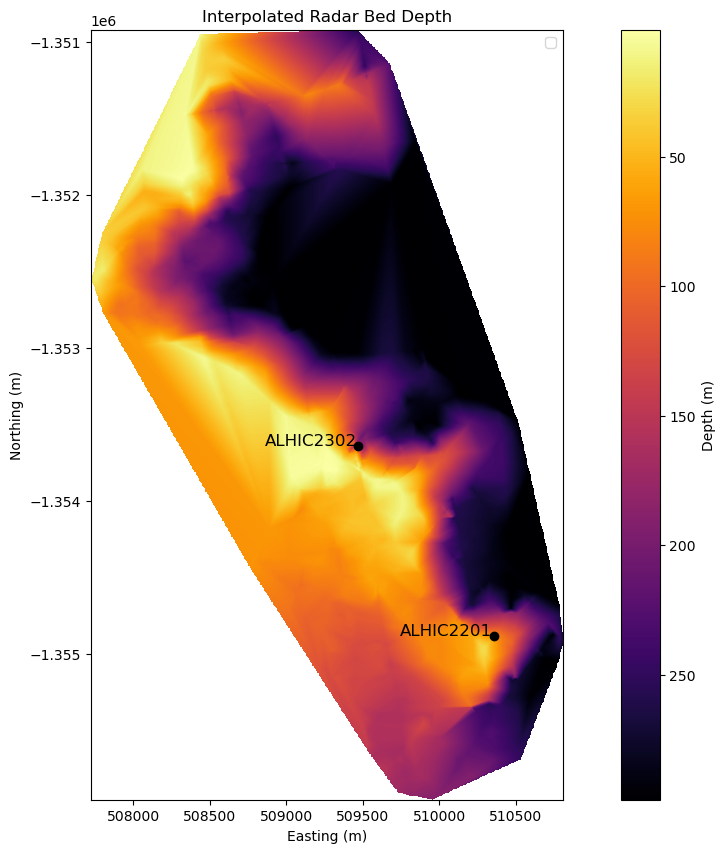

In [14]:
# Make a figure

fig, ax = plt.subplots(figsize=(15, 10))

# Open the file using rasterio
with rasterio.open('../../../radar_picks/test.tif') as src:
    # Plot the GeoTIFF
    show(src, ax=ax, cmap='inferno_r')
    
    # Add colorbar
    cbar = plt.colorbar(ax.images[0], ax=ax, orientation='vertical')
    cbar.set_label('Depth (m)')
    cbar.ax.invert_yaxis()

#%% add info to the right subplot
for core in [ALHIC2302,ALHIC2201]:

    x,y = transformer.transform(core.lat,core.lon)

    ax.plot(x, y, 'ko')
    ax.text(x-10, y, core.name, fontsize=12, ha = 'right')




# Add title and labels
ax.set_title('Interpolated Radar Bed Depth')
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')

# Add a legend
ax.legend()

# save the figure
fig.savefig('../../../figures/ah_24/radar.png')

## Let's design some surveys

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


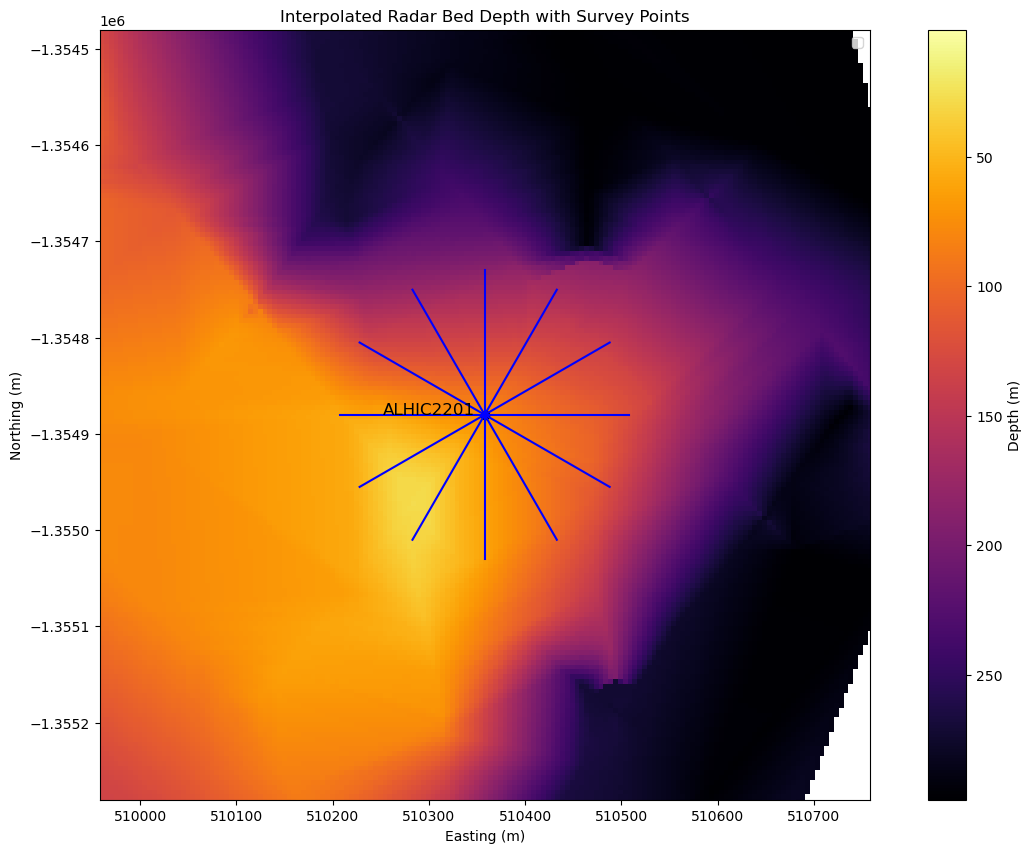

In [15]:
# set parameters
radius = 150
radial_in = 30

# get the northing/easting of the alhic2201 core site
x,y = transformer.transform(ALHIC2201.lat,ALHIC2201.lon)



# make a list of angles from 0 to 360 degrees (excluding 360) at radial_in intervals
angles = np.arange(0,360,radial_in)

# make a list of x,y coordinates at distance radius from x,y at each angle
coords = []
for angle in angles:
    coords.append((x+radius*np.cos(np.radians(angle)),y+radius*np.sin(np.radians(angle))))

# repeat the plot in the panel above but with each of the coords shown as blue dots

fig, ax = plt.subplots(figsize=(15, 10))

# Open the file using rasterio
with rasterio.open('../../../radar_picks/test.tif') as src:
    # Plot the GeoTIFF
    show(src, ax=ax, cmap='inferno_r')
    
    # Add colorbar
    cbar = plt.colorbar(ax.images[0], ax=ax, orientation='vertical')
    cbar.set_label('Depth (m)')
    cbar.ax.invert_yaxis()

# Add core points and labels
for core in [ALHIC2201]:
    x_core, y_core = transformer.transform(core.lat, core.lon)
    ax.plot(x_core, y_core, 'ko')
    ax.text(x_core - 10, y_core, core.name, fontsize=12, ha='right')

# # Add the new coordinates as blue dots
# for coord in coords:
#     ax.plot(coord[0], coord[1], 'bo')

# add the coordinates to the plot as blue lines, from each point to the point opposite it on the circle
for i in range(len(coords)):
    ax.plot([x,coords[i][0]],[y,coords[i][1]],'b-')
    

# Add title and labels
ax.set_title('Interpolated Radar Bed Depth with Survey Points')
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')

# Add a legend
ax.legend()

# limit the plot extent to the 400 m each side of the alhic2201 location
ax.set_xlim(x-400,x+400)
ax.set_ylim(y-400,y+400)

# Save the figure
fig.savefig('../../../figures/ah_24/radar_with_survey_points.png')

# convert coordinates to lat/lon and save them to a csv
coords_latlon = []
for coord in coords:
    lat, lon = transformer.transform(coord[0], coord[1], direction='INVERSE')
    coords_latlon.append((lat, lon))

# now save coords_latlon to a csv
df = pd.DataFrame(coords_latlon, columns=['Latitude', 'Longitude'])
df.to_csv('radar_survey_points.csv', index=False)



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


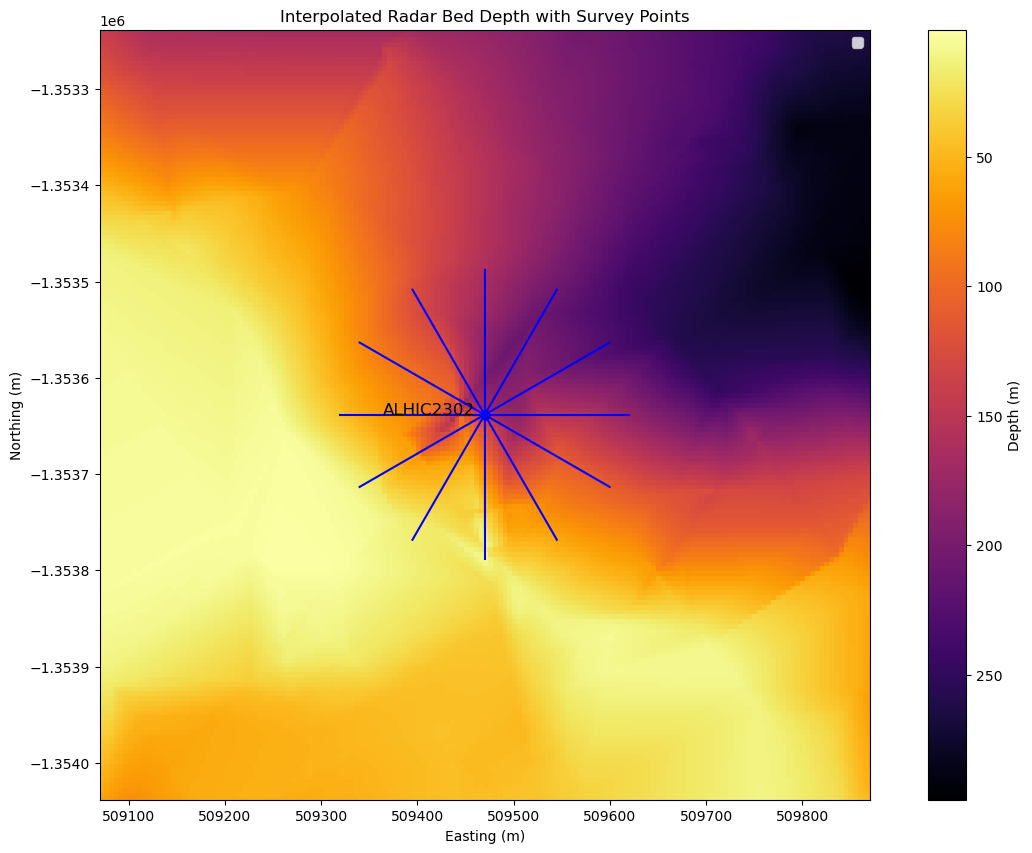

In [16]:
# set parameters
radius = 150
radial_in = 30

# get the northing/easting of the alhic2201 core site
x,y = transformer.transform(ALHIC2302.lat,ALHIC2302.lon)



# make a list of angles from 0 to 360 degrees (excluding 360) at radial_in intervals
angles = np.arange(0,360,radial_in)

# make a list of x,y coordinates at distance radius from x,y at each angle
coords = []
for angle in angles:
    coords.append((x+radius*np.cos(np.radians(angle)),y+radius*np.sin(np.radians(angle))))

# repeat the plot in the panel above but with each of the coords shown as blue dots

fig, ax = plt.subplots(figsize=(15, 10))

# Open the file using rasterio
with rasterio.open('../../../radar_picks/test.tif') as src:
    # Plot the GeoTIFF
    show(src, ax=ax, cmap='inferno_r')
    
    # Add colorbar
    cbar = plt.colorbar(ax.images[0], ax=ax, orientation='vertical')
    cbar.set_label('Depth (m)')
    cbar.ax.invert_yaxis()

# Add core points and labels
for core in [ALHIC2302]:
    x_core, y_core = transformer.transform(core.lat, core.lon)
    ax.plot(x_core, y_core, 'ko')
    ax.text(x_core - 10, y_core, core.name, fontsize=12, ha='right')

# # Add the new coordinates as blue dots
# for coord in coords:
#     ax.plot(coord[0], coord[1], 'bo')

# add the coordinates to the plot as blue lines, from each point to the point opposite it on the circle
for i in range(len(coords)):
    ax.plot([x,coords[i][0]],[y,coords[i][1]],'b-')
    

# Add title and labels
ax.set_title('Interpolated Radar Bed Depth with Survey Points')
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')

# Add a legend
ax.legend()

# limit the plot extent to the 400 m each side of the alhic2201 location
ax.set_xlim(x-400,x+400)
ax.set_ylim(y-400,y+400)

# Save the figure
fig.savefig('../../../figures/ah_24/radar_with_survey_points_2302.png')

# convert coordinates to lat/lon and save them to a csv
coords_latlon = []
for coord in coords:
    lat, lon = transformer.transform(coord[0], coord[1], direction='INVERSE')
    coords_latlon.append((lat, lon))

# now save coords_latlon to a csv
df = pd.DataFrame(coords_latlon, columns=['Latitude', 'Longitude'])
df.to_csv('radar_survey_points_2302.csv', index=False)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


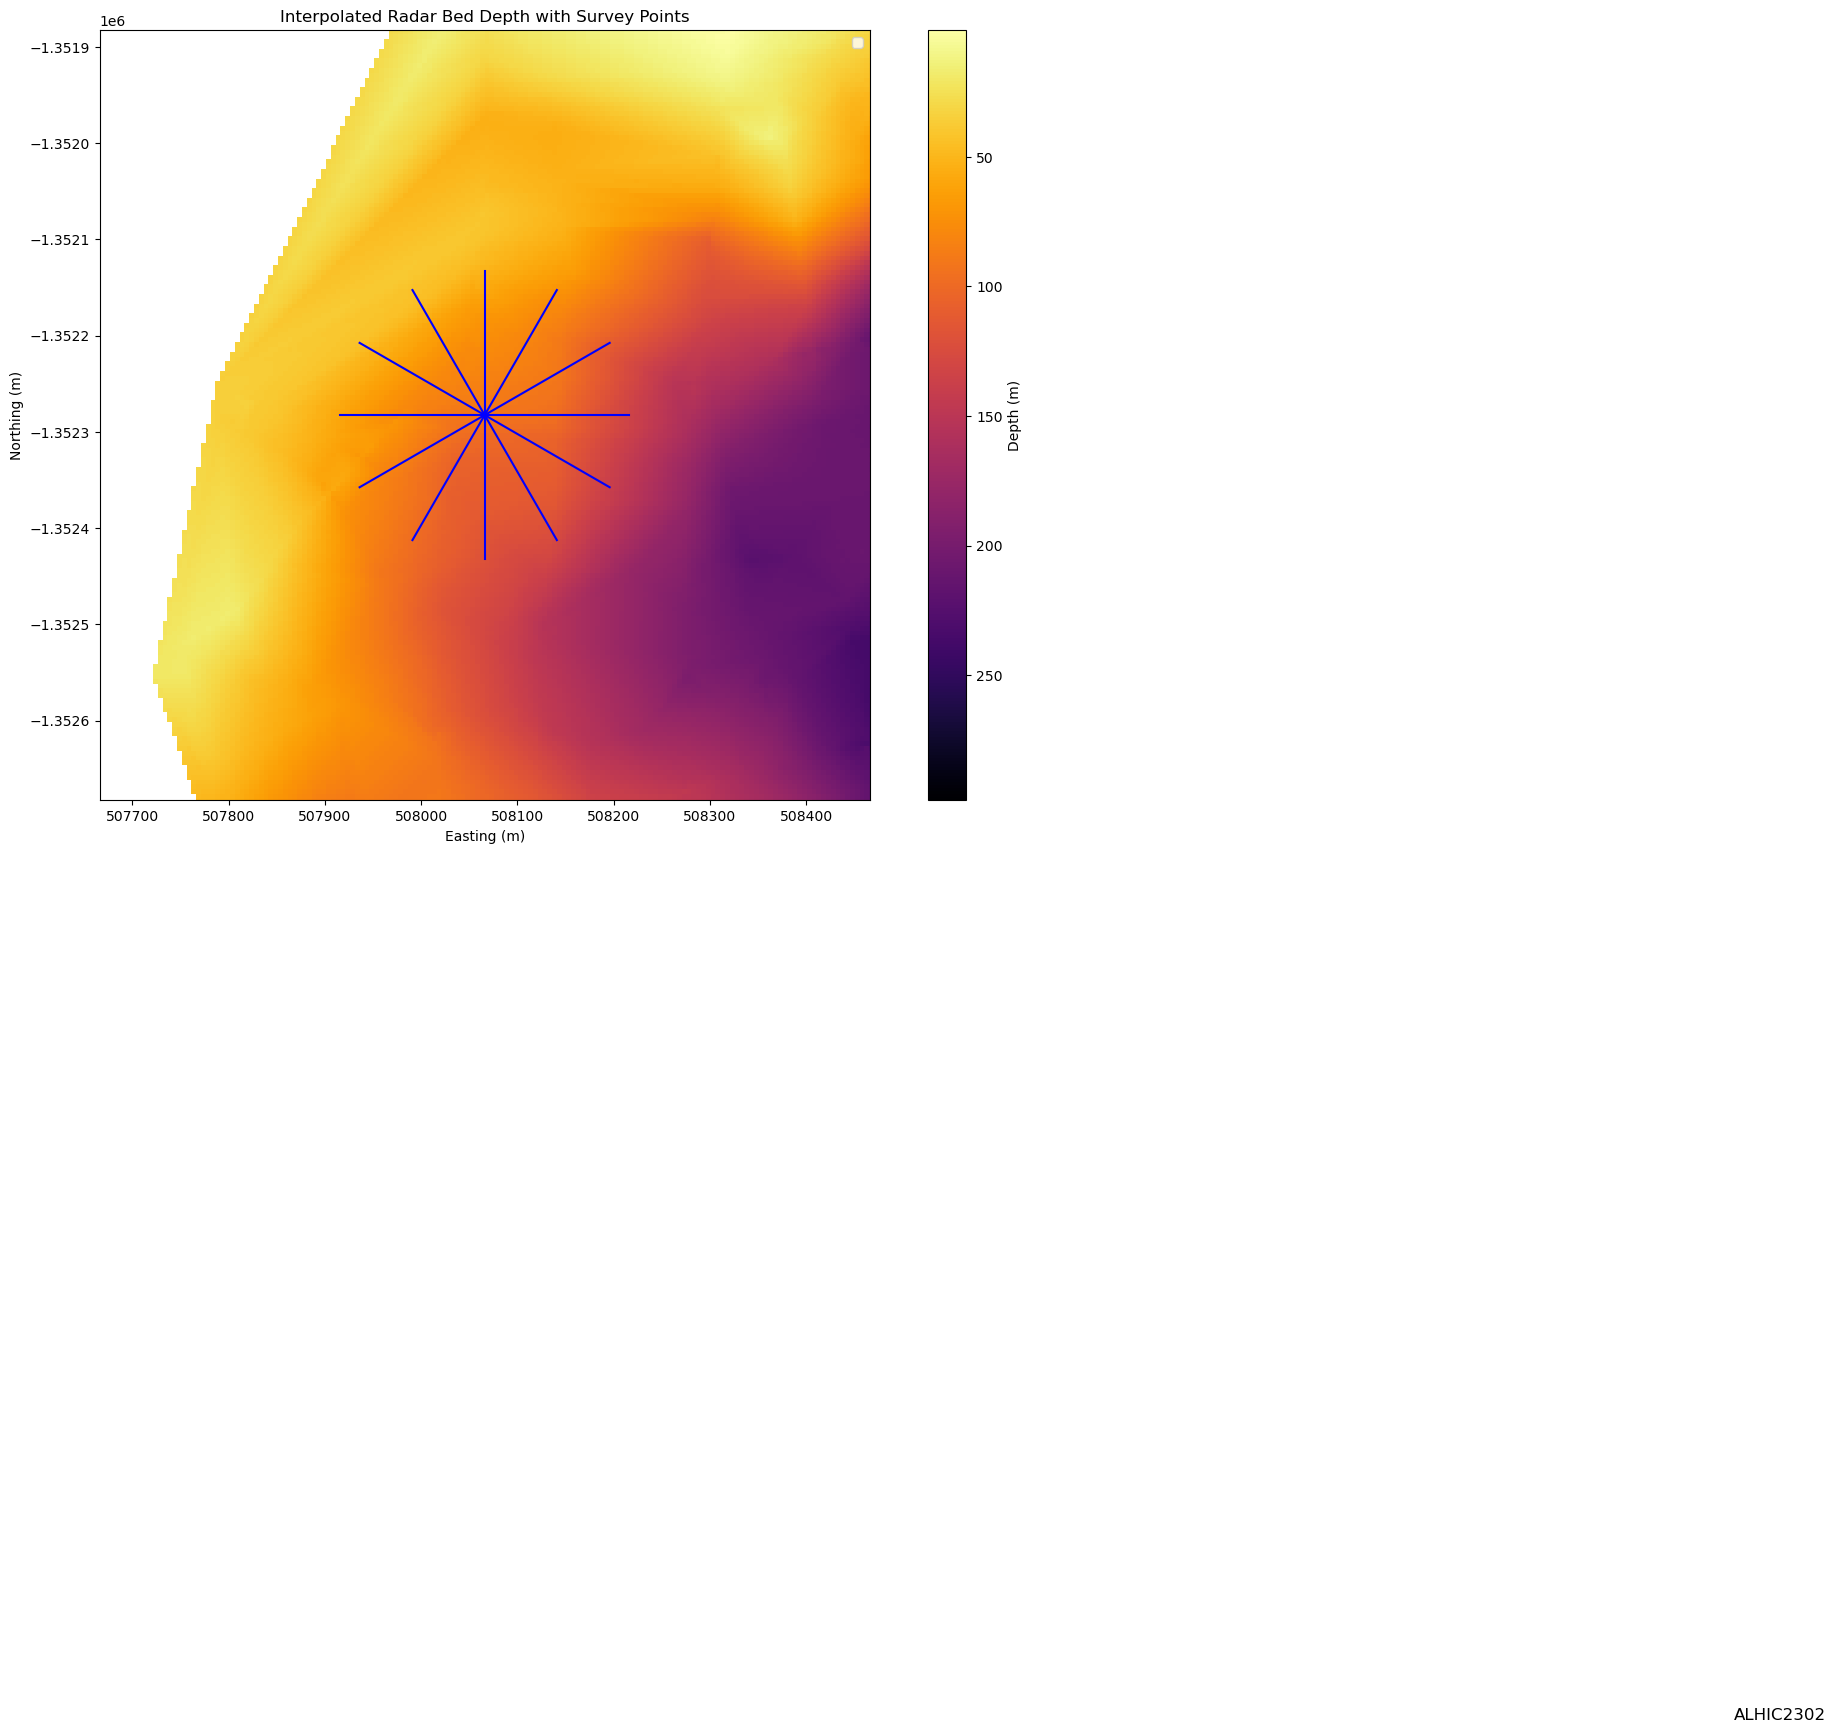

In [17]:
# set parameters
radius = 150
radial_in = 30

# get the northing/easting of the alhic2201 core site
x,y = transformer.transform(ALHIC2301.lat,ALHIC2301.lon)



# make a list of angles from 0 to 360 degrees (excluding 360) at radial_in intervals
angles = np.arange(0,360,radial_in)

# make a list of x,y coordinates at distance radius from x,y at each angle
coords = []
for angle in angles:
    coords.append((x+radius*np.cos(np.radians(angle)),y+radius*np.sin(np.radians(angle))))

# repeat the plot in the panel above but with each of the coords shown as blue dots

fig, ax = plt.subplots(figsize=(15, 10))

# Open the file using rasterio
with rasterio.open('../../../radar_picks/test.tif') as src:
    # Plot the GeoTIFF
    show(src, ax=ax, cmap='inferno_r')
    
    # Add colorbar
    cbar = plt.colorbar(ax.images[0], ax=ax, orientation='vertical')
    cbar.set_label('Depth (m)')
    cbar.ax.invert_yaxis()

# Add core points and labels
for core in [ALHIC2302]:
    x_core, y_core = transformer.transform(core.lat, core.lon)
    ax.plot(x_core, y_core, 'ko')
    ax.text(x_core - 10, y_core, core.name, fontsize=12, ha='right')

# # Add the new coordinates as blue dots
# for coord in coords:
#     ax.plot(coord[0], coord[1], 'bo')

# add the coordinates to the plot as blue lines, from each point to the point opposite it on the circle
for i in range(len(coords)):
    ax.plot([x,coords[i][0]],[y,coords[i][1]],'b-')
    

# Add title and labels
ax.set_title('Interpolated Radar Bed Depth with Survey Points')
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')

# Add a legend
ax.legend()

# limit the plot extent to the 400 m each side of the alhic2201 location
ax.set_xlim(x-400,x+400)
ax.set_ylim(y-400,y+400)

# Save the figure
fig.savefig('../../../figures/ah_24/radar_with_survey_points_2301.png')

# convert coordinates to lat/lon and save them to a csv
coords_latlon = []
for coord in coords:
    lat, lon = transformer.transform(coord[0], coord[1], direction='INVERSE')
    coords_latlon.append((lat, lon))

# now save coords_latlon to a csv
df = pd.DataFrame(coords_latlon, columns=['Latitude', 'Longitude'])
df.to_csv('radar_survey_points_2301.csv', index=False)
